# LASTDANCE: Layerwise Activation Similarity to Training Data for Assessing Non-Confirming Events

This is a quick tutorial notebook for LASTDANCE: a novel method for determining anomalous points in a deep neural network using the trajectory of a point through every layer, rather than a single network. 

Existing work tries to find "The optimal layer" to perform an "early exit" which maximizes probability of performance with ability to detect points which are out of distribution. We take a more greedy approach: we want to classify based upon the best possible layer for classification performance (i.e. the penultimate layer), but we want to detect anomalies well despite potential feature overlap. To do this, we leverage intuition that points in-distribution from the same class will "ride together" through the network, while overlapping-yet-out-of-distribution points will be strewn randomly about the feature space, even if they happen to overlap with in-distribution points on any individual layer.

## Training a Neural Network

Simple code to train a neural network. In particular, we use ResNet18 upon cifar10, which has a high chance of exhibiting this failure case due to its many batch norm layers, which cause spurious overlap more frequently.

In [ ]:
!pip install umap-learn[plot]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((63,63)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

#net = torchvision.models.alexnet(weights='IMAGENET1K_V1')
#net.classifier[6] = torch.nn.Linear(4096, 10)
net = torchvision.models.resnet18(weights='IMAGENET1K_V1')
net.fc = torch.nn.Linear(512, 10)
net.to("cuda")
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
     
    print(f'[{epoch + 1}] loss: {running_loss}')

print('Finished Training')

[1] loss: 1006.3190593943
[2] loss: 490.62917819805443
[3] loss: 303.51007778942585
[4] loss: 199.93928139237687
[5] loss: 132.20114818681031
[6] loss: 92.92387853353284
[7] loss: 70.39655591512565
[8] loss: 61.26088837487623
[9] loss: 52.148786252422724
[10] loss: 38.44497007066093
[11] loss: 35.20744346638094
[12] loss: 34.23025352600962
[13] loss: 27.316730699101754
[14] loss: 23.73006668248854
[15] loss: 23.01292324750102
[16] loss: 18.70740168289558
[17] loss: 16.312263477706438
[18] loss: 18.792451479857846
[19] loss: 15.312844501964719
[20] loss: 12.235176720769232
[21] loss: 10.468536729425978
[22] loss: 9.462827699018817
[23] loss: 10.334897726092095
[24] loss: 10.786711609998747
[25] loss: 11.786623747157137
[26] loss: 8.966242930840053
[27] loss: 7.1833479773158615
[28] loss: 7.456657803521011
[29] loss: 9.045662493066175
[30] loss: 7.671255750809905
[31] loss: 7.065880822415693
[32] loss: 7.002774076743663
[33] loss: 6.646648387329606
[34] loss: 6.175977643625174
[35] loss:

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


## Getting 2D Projections using UMAP 

Getting 2d projections of features is simple with umap, and provides a straightforward unsupervised mechanism for making this problem computationally tractable. Below is code for creating a feature extractor for an arbitrary layer.

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
nodes, _ = get_graph_node_names(net)
print(nodes[-2])
feature_extractor = create_feature_extractor(
 	net, return_nodes=[nodes[-2]])
out = feature_extractor(torch.ones(1, 3, 63,63).cuda())
print(out)

feats = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        feat = feature_extractor(images)[nodes[-2]]
        for b in feat:
          feats.append(b.cpu().numpy())

flatten
{'flatten': tensor([[0.8902, 0.9924, 0.9249, 1.1882, 0.9040, 1.0057, 0.7175, 1.2720, 0.9013,
         1.0279, 1.0222, 0.8723, 1.0072, 0.9274, 1.0104, 0.9291, 0.7417, 1.4671,
         0.7354, 0.8659, 1.0989, 1.1122, 0.8664, 0.9812, 0.9939, 0.8459, 1.0835,
         1.0467, 0.8599, 0.8871, 0.9464, 0.9909, 0.8991, 1.0188, 0.8617, 0.9045,
         0.9754, 1.0337, 0.7367, 1.0543, 0.9889, 0.8520, 0.8495, 0.9799, 1.0100,
         0.9320, 0.9026, 1.4768, 1.1033, 0.9775, 0.8623, 1.1653, 1.0183, 0.9813,
         1.0512, 0.9876, 1.0837, 0.9048, 1.1882, 1.0183, 1.0035, 0.8799, 1.0101,
         1.1052, 1.0860, 0.9818, 0.8601, 0.9235, 1.1418, 0.5803, 0.7789, 0.9203,
         0.8905, 0.9324, 0.7104, 0.7965, 0.8157, 0.9971, 1.0950, 0.9459, 1.0561,
         0.9796, 0.9917, 1.2674, 0.8835, 0.8865, 1.0165, 0.8355, 1.1224, 0.9507,
         0.9193, 0.9569, 0.9341, 1.0694, 1.0404, 0.7291, 0.9478, 0.8385, 0.8987,
         0.9451, 1.1122, 1.1456, 0.9604, 1.0968, 0.9634, 0.7849, 0.9155, 1.1485,
        

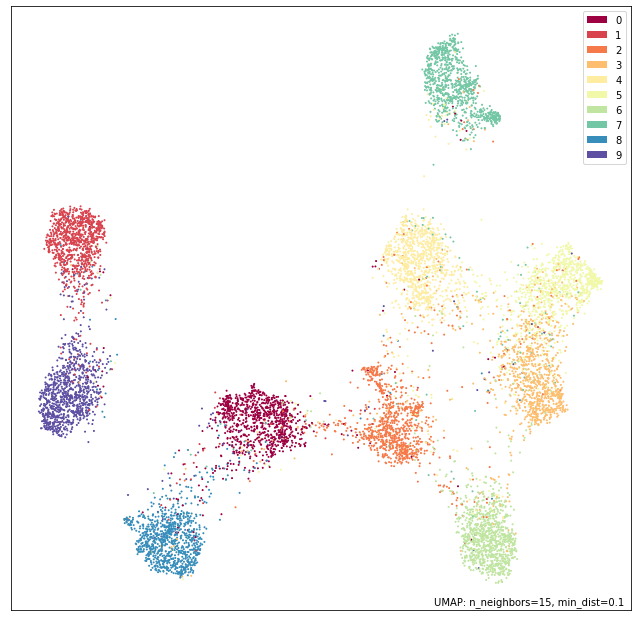

In [ ]:
import umap
import umap.plot

mapper = umap.UMAP().fit(np.array(feats))
umap.plot.points(mapper, labels=np.array(testset.targets))

## The Spurious Overlap Problem

Here we produce a toy example of a dataset (combined CIFAR10 and SVHN) which exhibits spurious overlap between features in-distribution and out-of-distribution. Because of the batch norm layers, ResNet18 will often place a clearly out-of-domain point on top of an in-distribution feature cluster, which will fail for both softmax-based and feature-based methods using a single layer. 

In [ ]:
from torchvision.datasets import SVHN

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((63,63)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

testset_SVHN = SVHN(root='./data', split='test',
               download=True, transform=transform)
testloader_SVHN = torch.utils.data.DataLoader(testset_SVHN, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

feats_SVHN = []

with torch.no_grad():
    for data in testloader_SVHN:
        images, labels = data
        images = images.to("cuda")
        feat = feature_extractor(images)[nodes[-2]]
        for b in feat:
          feats_SVHN.append(b.cpu().numpy())

mix_dataset = [*feats, *feats_SVHN]
mix_labs = [*testset.targets, *[10 for _ in testset_SVHN.labels]]

Using downloaded and verified file: ./data/test_32x32.mat


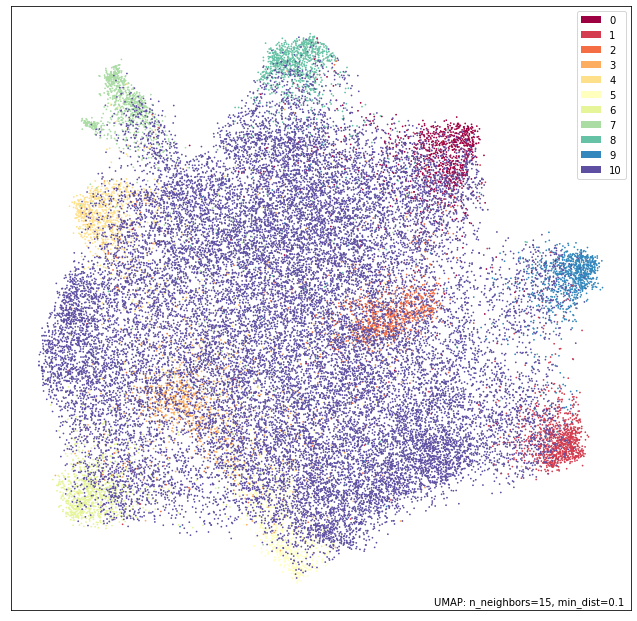

In [ ]:
mapper = umap.UMAP().fit(np.array(mix_dataset))
umap.plot.points(mapper, labels=np.array(mix_labs))

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

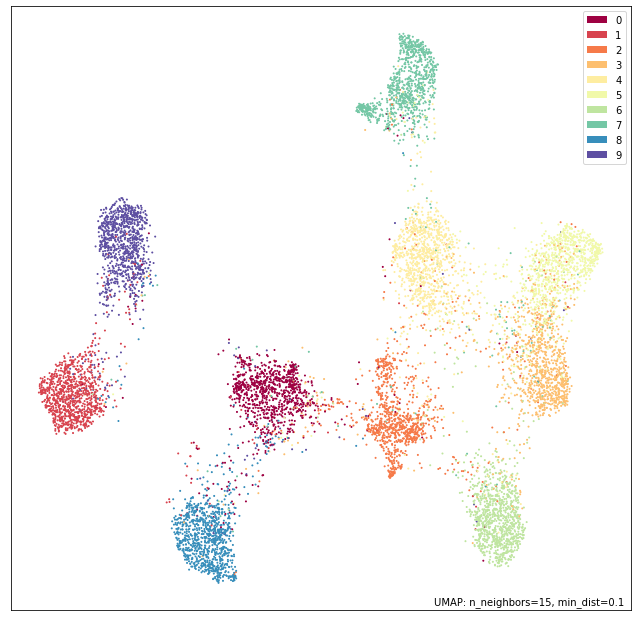

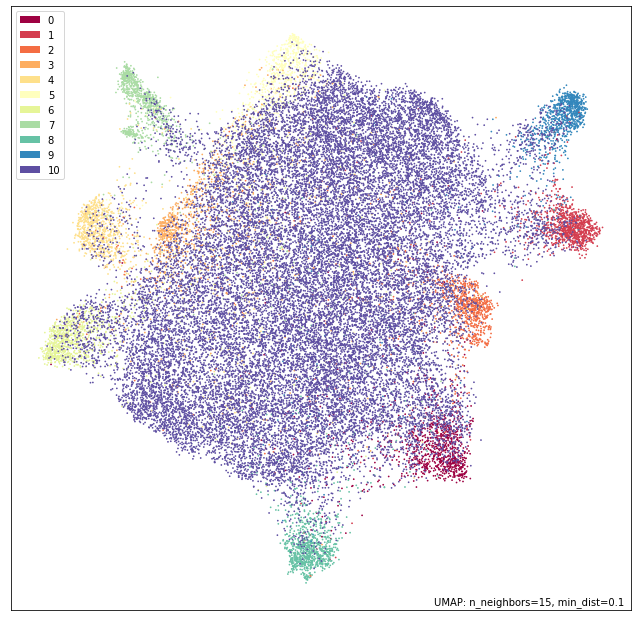

In [ ]:
whichlayer = -7
print(nodes)

feature_extractor_2 = create_feature_extractor(
 	net, return_nodes=[nodes[whichlayer]])
out = feature_extractor_2(torch.ones(1, 3, 63,63).cuda())
print(out)

feats_2 = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        feat = feature_extractor_2(images)[nodes[whichlayer]]
        for b in feat:
          feats_2.append(b.cpu().numpy().flatten())

mapper = umap.UMAP().fit(np.array(feats_2))
umap.plot.points(mapper, labels=np.array(testset.targets))

feats_SVHN_2 = []

with torch.no_grad():
    for data in testloader_SVHN:
        images, labels = data
        images = images.to("cuda")
        feat = feature_extractor_2(images)[nodes[whichlayer]]
        for b in feat:
          feats_SVHN_2.append(b.cpu().numpy().flatten())

mix_dataset_2 = [*feats_2, *feats_SVHN_2]

mapper = umap.UMAP().fit(np.array(mix_dataset_2))
umap.plot.points(mapper, labels=np.array(mix_labs))

# Assessing Every Layer

If you use UMAP on every layer to project each feature down to 2 dimensions, given $L$ layers and $n$ points, features for every layer can be modeled as a list of size $(n, L, 2)$, or flattened as $(n, 2L)$. This is a bit heavy to perform in google colab, so the script for this can be find in the repository under experiment.py.

What we find is that, broadly, points belonging to the same class will travel through the layers together, and points which are out of distribution will ping pong around every layer, such that even if they happen to overlap with in-distribution features on a certain layer, their trajectories are clearly anomalous when considering the entire path through the layers. Therefore, a mahalanobis distance to a gaussian mixture fit upon the trajectories is a more robust anomaly detection mechanism than mahalanobis distance to any layer on it's own, due to suprious correlation of features.

Below find a umap of the $(n, 2L)$ vector of trajectories of combined cifar10 (0-9) and svhn (10).

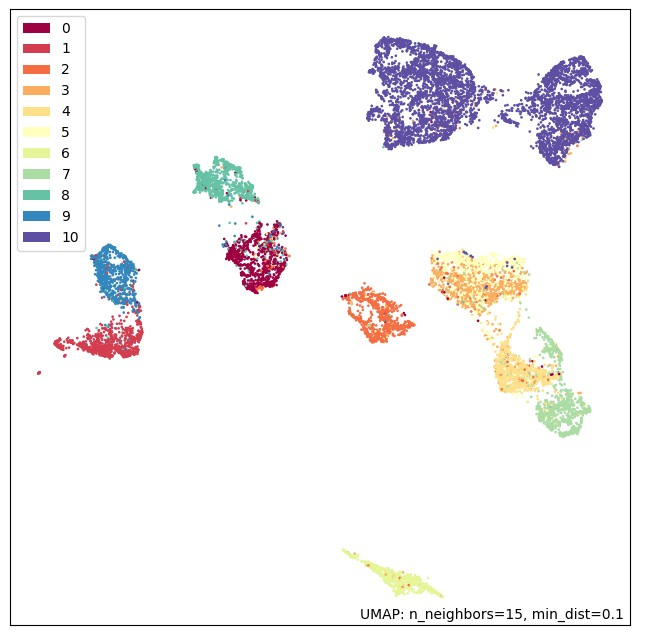